Prediction of Gas Probability using 3D Seismic Attributes from the Investigator 3DMSS

In [1]:
import sys
import os
sys.path.insert(0, r'c:\Personal\Gas_Prediction_from_Seismic_Attributes')
os.chdir(sys.path[0])

In [12]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import rasterio.mask
from rasterio.plot import show
from descartes import PolygonPatch
import fiona
import shap
import seaborn as sns

In [13]:
# set path to data directory
data_dir = r'data/inputs'

# set paths to key data sets
point_fn = os.path.join(data_dir, 'gas_discoveries_3857.gpkg')
#occurances = os.path.join(data_dir, 'All_ni_occurances_3577.gpkg')
raster_fns = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if '.tif' in x and 'xml' not in x]
point_fn, raster_fns

('data/inputs\\gas_discoveries_3857.gpkg',
 ['data/inputs\\RMS_3857.tif',
  'data/inputs\\RMS_Aspect_3857.tiff',
  'data/inputs\\RMS_Roughness_3857.tiff',
  'data/inputs\\RMS_slope_3857.tif'])

In [ ]:
# Read in the Gas Discoveries as a Dataframe and display the first 5 rows
df = gpd.read_file(point_fn)
df.head(3)

In [16]:
# Import the modelling area
with fiona.open("data/inputs/Model_Boundary_3857.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# Import Australian Coastline
#with fiona.open("data/1000m/Coastline.shp", "r") as shapefile:
#    coast = [feature["geometry"] for feature in shapefile]

In [17]:
# loop through Geotiff files and read bands into an array
data, names = [], []
for fn in raster_fns:
  with rasterio.open(fn, 'r') as src:
    # read the coordinate transform
    transf = src.transform
    # create an extent tuple containing (xmin, xmax, ymin, ymax) for the rasters
    region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    # read the data, derive a nodata mask and nullify nodata pixels
    d = src.read(1)
    d = d.astype('float64')
    nodata_mask = d == src.nodata
    d[nodata_mask] = np.nan
    # append data to data list and append file names to names list (remove .tif file extension)
    data.append(d)
    names.append(os.path.basename(fn).split('.')[0])

In [25]:
# Import the Training Set
nd = rasterio.open('data/training/gas_mask_v0.tif')

# read the coordinate transform
transf = nd.transform
# create an extent tuple containing (xmin, xmax, ymin, ymax) for the rasters
region = (nd.bounds.left, nd.bounds.right, nd.bounds.bottom, nd.bounds.top)
# read the data, derive a nodata mask and nullify nodata pixels
gas = nd.read(1)
gas = gas.astype('float64')
nodata_mask = gas == nd.nodata

In [26]:
# combine 2D raster arrays into 3D stack, print some details
data = np.stack(data)
print ('3D (Nbands, Nycolumns, Nxcolumns) data cube shape: {}'.format(data.shape))
print ('Data sets in cube:\n', names)

3D (Nbands, Nycolumns, Nxcolumns) data cube shape: (4, 1003, 1047)
Data sets in cube:
 ['RMS_3857', 'RMS_Aspect_3857', 'RMS_Roughness_3857', 'RMS_slope_3857']


In [27]:
# plot the data sets
patches = [PolygonPatch(c, edgecolor="red", facecolor="none", linewidth=1) for c in shapes]

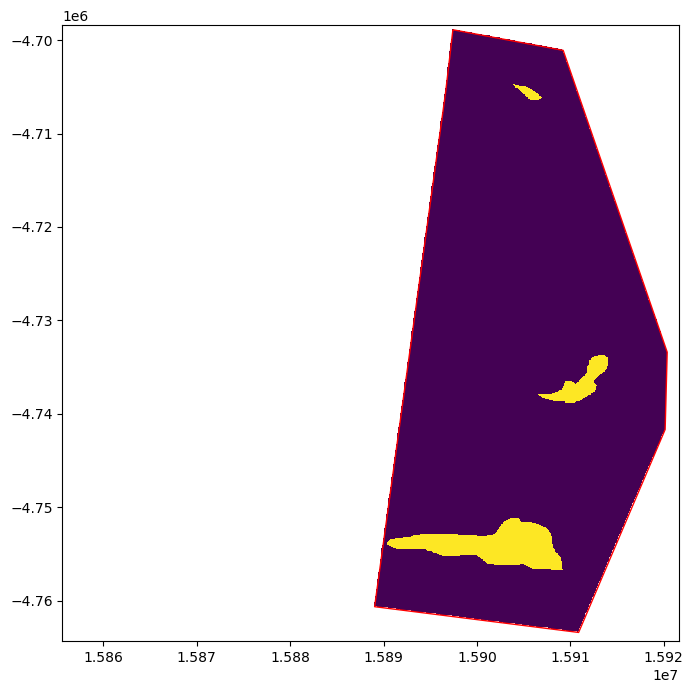

In [31]:
# Create the target variable
src = rasterio.open('data/training/gas_mask_v0.tif')

# read the coordinate transform
transf = src.transform
# create an extent tuple containing (xmin, xmax, ymin, ymax) for the rasters
region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
# read the data, derive a nodata mask and nullify nodata pixels
gas = src.read(1)
gas = gas.astype('float64')
nodata_mask = gas == src.nodata
gas[nodata_mask] = np.nan

# plot the mafics
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(gas, extent=region, interpolation='nearest')
ax.add_collection(mpl.collections.PatchCollection(patches, match_original=True))
plt.show()

X_pix data array shape is (1050141, 4), y_pix labels array shape is (1050141,)
X data array shape is (1050141, 4), y labels array shape is (1050141,)


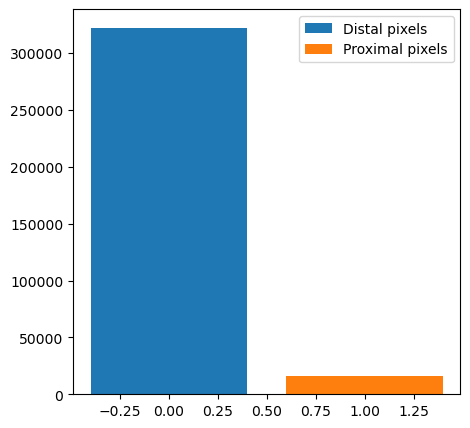

In [32]:
# reshape arrays to derive a X (Npixels, Nfeatures) array and y (Npixels) array
X_pix = data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T
y_pix = mafics.flatten()
print ('X_pix data array shape is {}, y_pix labels array shape is {}'.format(X_pix.shape, y_pix.shape))

# remove nodata pixels from both data sets
X = X_pix[~np.isnan(y_pix)]
y = y_pix[~np.isnan(y_pix)]
print ('X data array shape is {}, y labels array shape is {}'.format(X.shape, y.shape))

# summarise the data set
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(0, y[y==0].shape, label='Distal pixels')
ax.bar(1, y[y==1].shape, label='Proximal pixels')
ax.legend()
plt.show()

Train the Baseline Model